In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.27G/2.29G [00:13<00:00, 268MB/s]
100% 2.29G/2.29G [00:14<00:00, 175MB/s]


In [ ]:
!unzip "/content/chest-xray-pneumonia.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/dataset/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/dataset/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/dataset/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/dataset/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/dataset/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/dataset/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/dataset/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/dataset/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/dataset/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /content/dataset/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: /content/dataset/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: /content/dataset/chest_

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [ ]:
train_dataset_path = "/content/dataset/chest_xray/chest_xray/train"

CONFIG = {
    "IM_SIZE":256,
    "BATCH_SIZE":32,
}

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset_path,
    image_size= (CONFIG["IM_SIZE"],CONFIG["IM_SIZE"]),
    batch_size=CONFIG["BATCH_SIZE"],
    seed = 123,
    shuffle= True,
    subset="training",
    validation_split = 0.2,
    label_mode = "binary",
)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset_path,
    image_size= (CONFIG["IM_SIZE"],CONFIG["IM_SIZE"]),
    batch_size=CONFIG["BATCH_SIZE"],
    seed = 123,
    shuffle= True,
    subset="validation",
    validation_split = 0.2,
    label_mode = "binary",
)

Found 5216 files belonging to 2 classes.
Using 1043 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


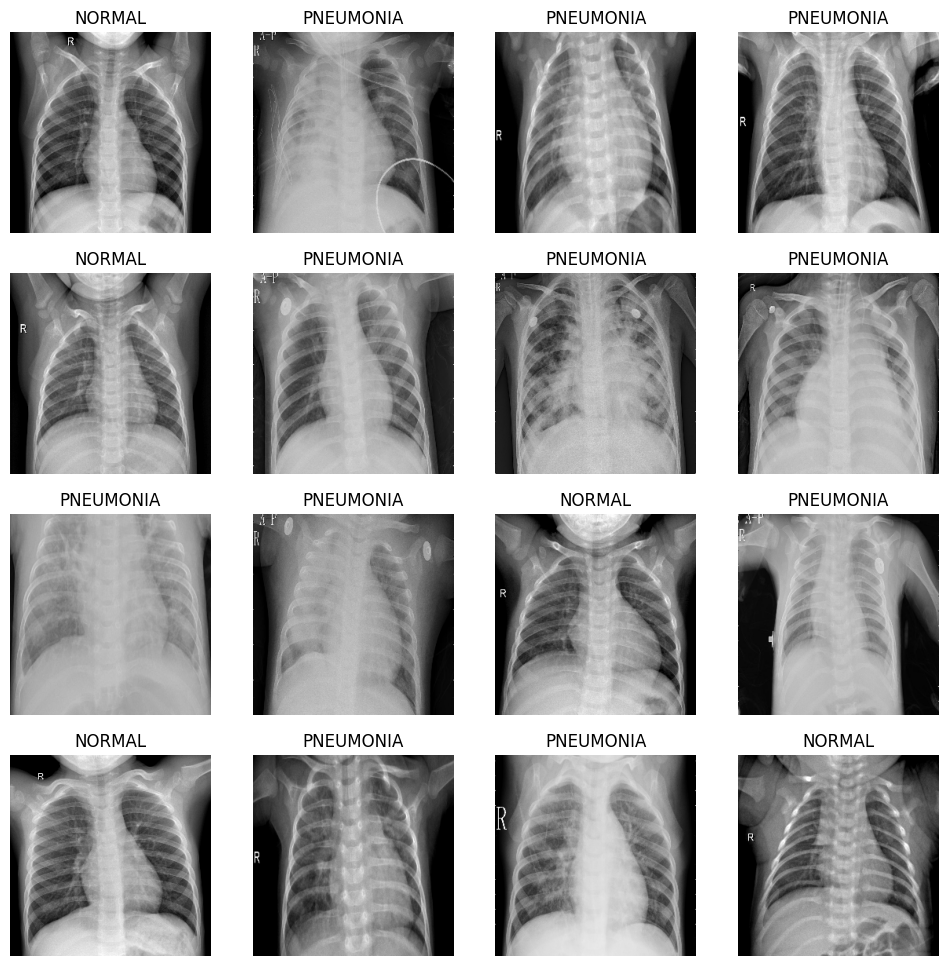

In [ ]:
plt.figure(figsize = (12,12))

for images,labels in train_ds.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.title(class_names[int(labels[i].numpy()[0])])
    plt.imshow(images[i]/255)
    plt.axis("off")

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",input_shape=(CONFIG["IM_SIZE"],CONFIG["IM_SIZE"],3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

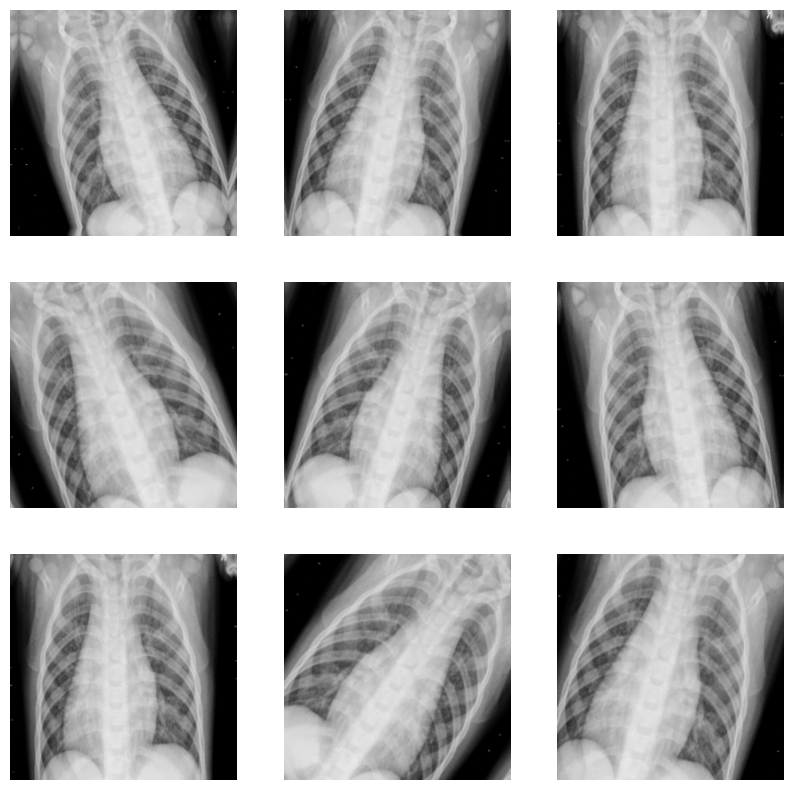

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
train_ds = train_ds.shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
print(f"Train Size: {len(train_ds)} Val Size: {len(val_ds)}")
print(train_ds)
print(val_ds)

Train Size: 131 Val Size: 33
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape = (CONFIG["IM_SIZE"],CONFIG["IM_SIZE"],3)),
    data_augmentation,

    tf.keras.layers.Conv2D(filters = 32,kernel_size = 3,strides = 1,padding = "valid",activation = "relu"),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(filters = 64,kernel_size = 3,strides = 1,padding = "valid",activation = "relu"),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(filters = 128,kernel_size = 3,strides = 1,padding = "valid",activation = "relu"),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512,activation = "relu"),
    tf.keras.layers.Dense(100,activation = "relu"),

    tf.keras.layers.Dense(1,activation = "sigmoid")
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                 

In [ ]:
model.compile(optimizer='adam',loss = tf.keras.losses.binary_crossentropy,metrics = ['accuracy'])

In [ ]:
history = model.fit(train_ds,validation_data = val_ds,epochs = 10)

Epoch 1/10
131/131 [==============================] - 64s 186ms/step - loss: 0.5242 - accuracy: 0.7841 - val_loss: 0.2084 - val_accuracy: 0.9137
Epoch 2/10
131/131 [==============================] - 51s 165ms/step - loss: 0.2476 - accuracy: 0.8998 - val_loss: 0.1979 - val_accuracy: 0.9128
Epoch 3/10
131/131 [==============================] - 47s 164ms/step - loss: 0.1959 - accuracy: 0.9216 - val_loss: 0.3221 - val_accuracy: 0.8629
Epoch 4/10
131/131 [==============================] - 50s 192ms/step - loss: 0.1716 - accuracy: 0.9360 - val_loss: 0.1503 - val_accuracy: 0.9434
Epoch 5/10
131/131 [==============================] - 46s 164ms/step - loss: 0.1691 - accuracy: 0.9367 - val_loss: 0.1193 - val_accuracy: 0.9482
Epoch 6/10
131/131 [==============================] - 50s 191ms/step - loss: 0.1571 - accuracy: 0.9394 - val_loss: 0.2768 - val_accuracy: 0.8878
Epoch 7/10
131/131 [==============================] - 48s 163ms/step - loss: 0.1463 - accuracy: 0.9439 - val_loss: 0.0986 - val_ac

In [ ]:
model.evaluate(val_ds)

33/33 [==============================] - 6s 142ms/step - loss: 0.1644 - accuracy: 0.9406


[0.16442424058914185, 0.9405561089515686]

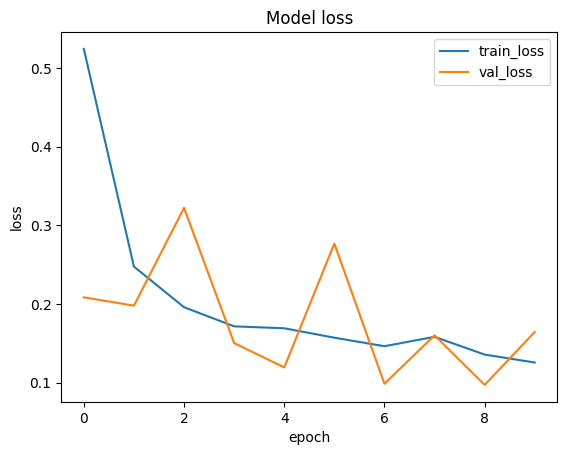

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["train_loss","val_loss"])
plt.show()

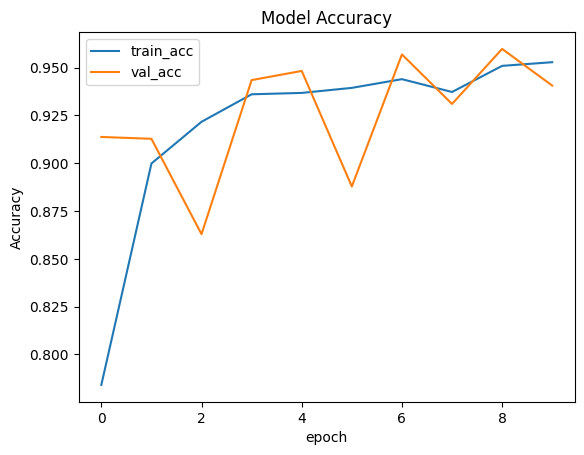

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(["train_acc","val_acc"])
plt.show()

1/1 [==============================] - 0s 19ms/step


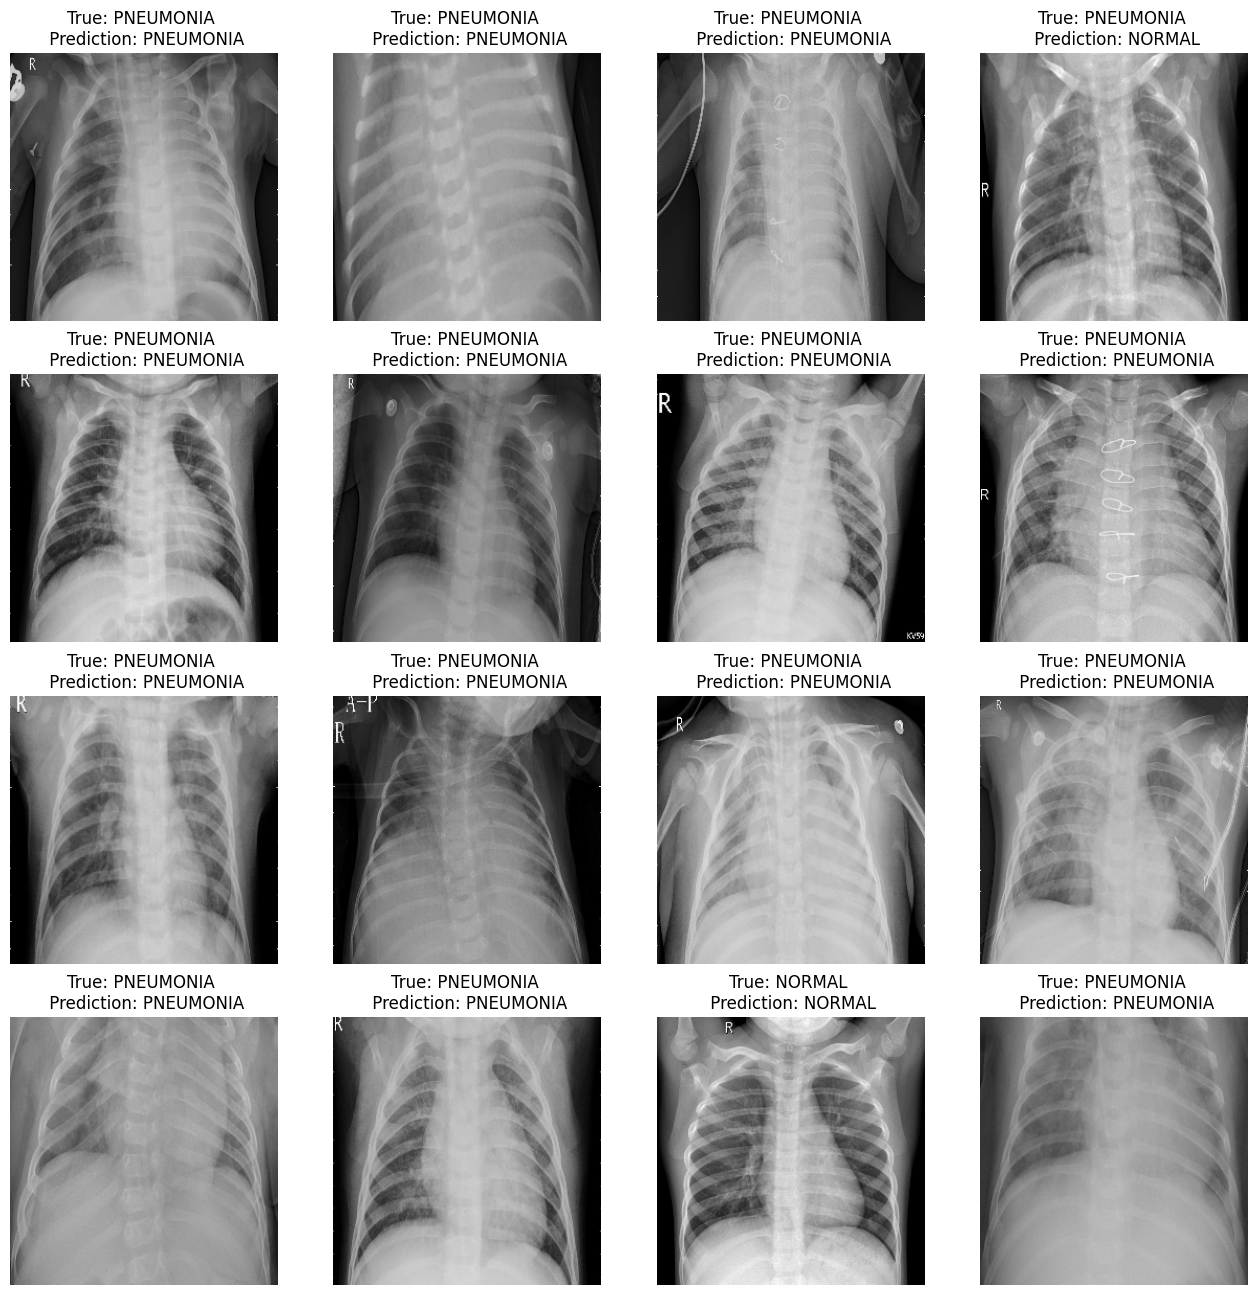

In [ ]:
plt.figure(figsize = (16,16))
text = ""
for images,labels in val_ds.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255)
    true_label = class_names[int(labels[i].numpy()[0])]
    img_pred = tf.expand_dims(images[i],axis = 0)
    prediction = model.predict(img_pred)
    if prediction >= 0.5:
      text = "PNEUMONIA"
    else:
      text = "NORMAL"
    plt.title(f"True: {true_label} \n Prediction: {text}")
    plt.axis("off")